In [1]:
import numpy as np
import sys
import gsw
import glob
import xarray as xr
import numpy as np
from scipy import integrate
from copy import deepcopy 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import cmocean
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from xgcm import Grid 
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [8]:
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

In [57]:
## Load 2D Monthly data...SSH 
data_dir= ECCO_dir + '/nctiles_monthly'
# ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, vars_to_load=['SSHDYN','OBPNOPAB', 'RHOAnoma'], \
#                                                              years_to_load=range(2011,2018)).load() # ,'PHIHYD','RHOAnoma','SALT','UVEL','VVEL'    
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                                           vars_to_load=['ETAN', 'PHIBOT'],\
                                           years_to_load=range(1993,2018)).load()    
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))
tile_num = 10
lons = ecco_monthly_ds.XC.sel(tile=tile_num)
lats = ecco_monthly_ds.YC.sel(tile=tile_num)

loading files of  ETAN
loading files of  PHIBOT


In [54]:
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask)

In [60]:
SSH_global_mean_mon = (ecco_monthly_ds.ETAN*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area # global mean time series 
ssh_mgm = ecco_monthly_ds.ETAN # - SSH_global_mean_mon  # subtract global spatial mean time series 
ssh_anom = ssh_mgm - ssh_mgm.mean(dim='time') 

In [53]:
# AVISO SLA 
# av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_obs_ssh_allsat_l4_pt25deg_P1D_1644446947552_2011_2017.nc'
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_obs_ssh_my_allsat_l4_duacs_ptdeg_P1D_1993_2020.nc'
av = xr.open_dataset(av_path)
# av_time_o = np.where((av.time > ecco_monthly_ds.time[0]) & (av.time < ecco_monthly_ds.time[-1]))[0]
av_time_o = range(len(av.time))
avsla = av.sla[av_time_o,:,:]
# avsla = avsla - avsla.mean(dim='time')
avsla_mean = avsla.sel(time=slice("1993-01-01", "2017-12-31")).mean(dim='time') # mean over range we have ECCO data 
avsla = avsla - avsla_mean
pavsla = avsla.polyfit(dim='time', deg=1)
avsla_trend = xr.polyval(avsla['time'], pavsla.polyfit_coefficients)
avsla_detrend = avsla - avsla_trend

In [11]:
# pick one site to consider time series 
lon_site = -84; lat_site = 28; 
ecli = np.where((lons > lon_site-.65) & (lons < lon_site+.65) & (lats > lat_site-.65) & (lats < lat_site+.65))
eclon = lons[ecli[0][0], ecli[1][0]]; eclat = lats[ecli[0][0], ecli[1][0]]
# find aviso index to site selected above
avloni = np.where((av.longitude > eclon-.15) & (av.longitude < eclon+.15))[0][0]
avlati = np.where((av.latitude > eclat-.15) & (av.latitude < eclat+.15))[0][0]

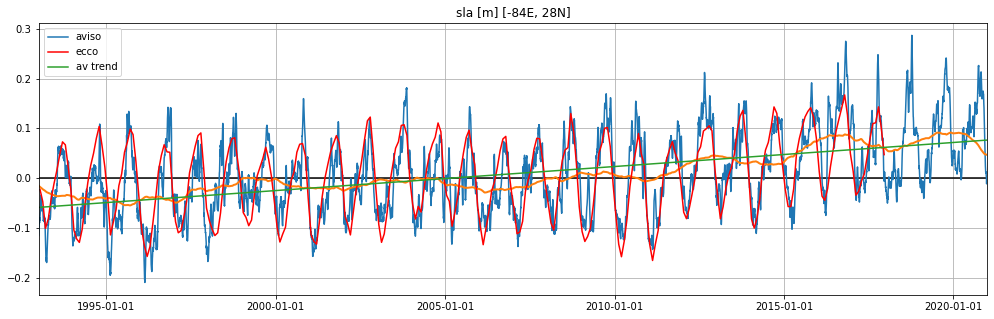

In [62]:
filt_win = 365*2

f, ax = plt.subplots(1,1,figsize=(17,5))
ax.plot([av.time[0].data, av.time[-1].data], [0, 0],  color='k')
ax.plot(av.time[av_time_o], avsla[:, avlati, avloni], label='aviso'); 
ax.plot(av.time[av_time_o], \
        (np.convolve(avsla[:, avlati, avloni],np.ones(filt_win))/filt_win)[np.int(filt_win/2):-np.int(filt_win/2)+1], linewidth=2); 
ax.plot(ecco_monthly_ds.time, ssh_anom[:,tile_num,ecli[0][0], ecli[1][0]], label='ecco', color='r')
ax.plot(av.time[av_time_o], avsla_trend[:, avlati, avloni], label='av trend')
ax.set_title('sla [m] [' + str(lon_site) + 'E, ' + str(lat_site) + 'N]'); 
ax.legend(); ax.grid(); ax.set_xlim([av.time[0].data, av.time[-1].data])
ax.set_xticks([np.datetime64('1995'), np.datetime64('2000'), \
               np.datetime64('2005'), np.datetime64('2010'), np.datetime64('2015'), np.datetime64('2020')])
# ax.set_xlim([ecco_monthly_ds.time[0].data,ecco_monthly_ds.time[-1].data])
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_02_24/GOM_sla_ecco_aviso_2011_2017.jpg', dpi=250)

NameError: name 'lon_range' is not defined

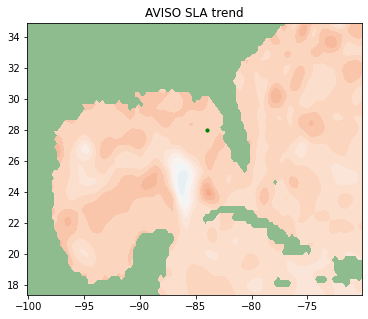

In [66]:
f, ax = plt.subplots(1,1,figsize=(6,5)); clim = [-0.02, 0.02];
colMap = plt.get_cmap('RdBu_r'); # colMap.set_over(color='r');
Kc = ax.contourf(av.longitude,av.latitude,pavsla.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365, \
            levels=np.arange(clim[0], clim[-1], 0.001), vmin=clim[0],vmax=clim[-1], cmap=colMap); ax.set_facecolor('#8FBC8F')
ax.scatter(lon_site,lat_site,s=10,color='g')
ax.set_title('AVISO SLA trend'); ax.set_xlim(lon_range); ax.set_ylim(lat_range)